### Note

This is heavily guided and inspired by https://medium.com/radon-dev/als-implicit-collaborative-filtering-5ed653ba39fe

## Implicit vs Explicit Data

Explicit Data are data that shows clearly the liking for a product such as ratings 

Implicit data are data gathered from user behaviour that shows a favourtism to a product, implicit data are getting popular in the case of spotify and netflix

## Alternating Least Squares (ALS)

ALS relies heavily on the fact that we use matrix reduction to categorise our taste in products. It is due to the fact that there can be millions of dimensions but these millions of items might just expresses a small subset of different taste

### Matrix Reduction

Matrix reduction is the method where we reduce a matrix to a smaller matrix to represent a smaller subset of important features so that we achieve a state of 'all items by some dimensions' and 'users by some dimensions' 

If we can express each user as a vector of their taste values, and at the same time express each item as a vector of what tastes they represent. You can see we can quite easily make a recommendation. This also gives us the ability to find connections between users who have no specific items in common but share common tastes.

ALS is an iterative optimization process where we for every iteration try to arrive closer and closer to a factorized representation of our original data.

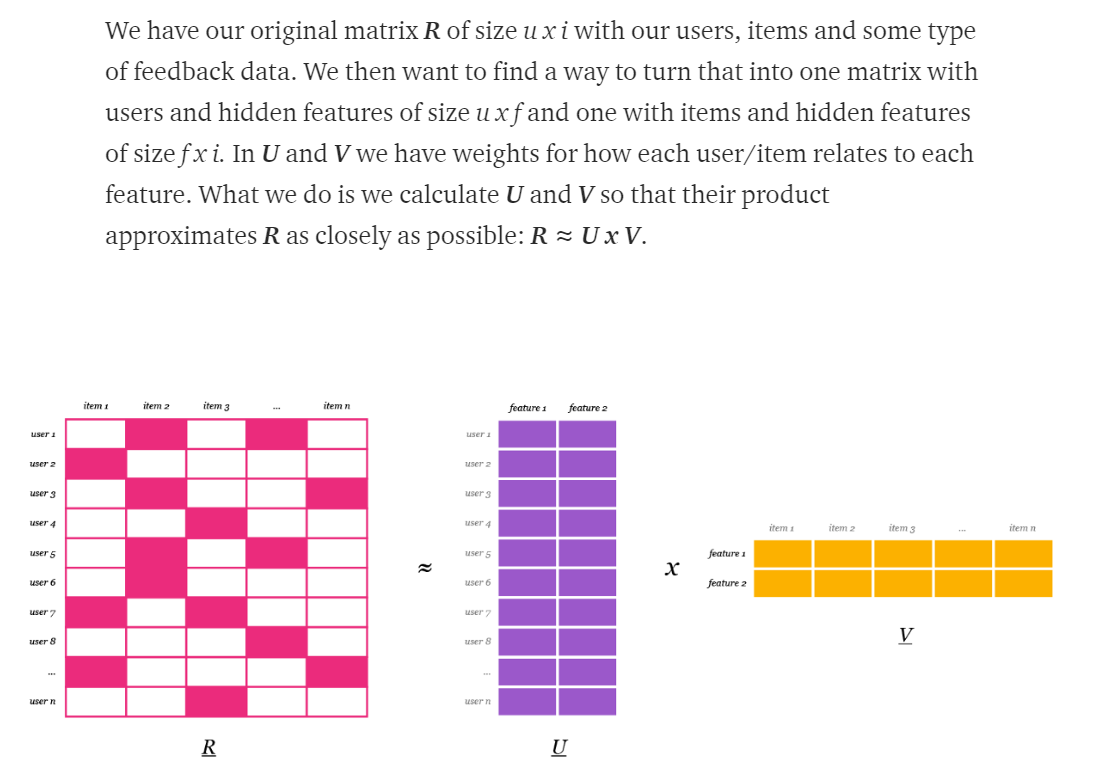

we assign some random weights in U and V and the nusing the least square method, we try and find the closest approximation of 
U * V = R 

We also iteratively optimise U and fix V and vice versa

### Preferance and confidence

Their solution is to merge the preference (p) for an item with the confidence (c) we have for that preference. We start out with missing values as a negative preference with a low confidence value and existing values a positive preference but with a high confidence value. We can use something like play count, time spent on a page or some other form of interaction as the basis for calculating our confidence.

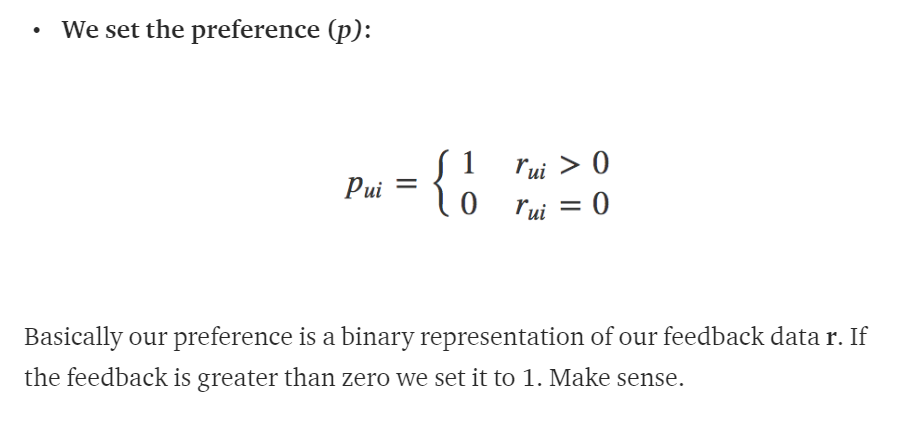

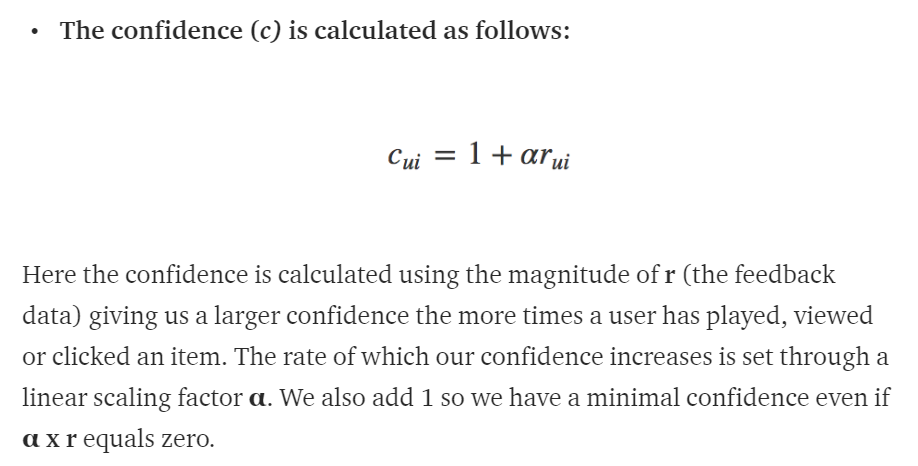

this means that as long as there is some feedback ,we classify the preference to be a postive one since it represents an implicit choice/decision made

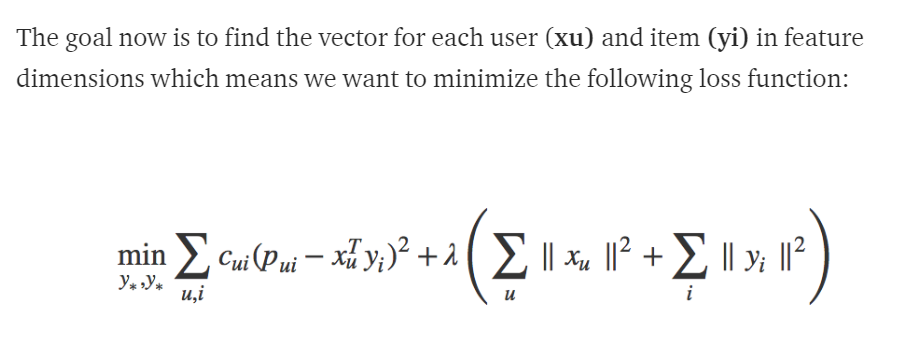

here, we are trying to find the difference between the preference from the feedback data against the matrix multiplication of the items 

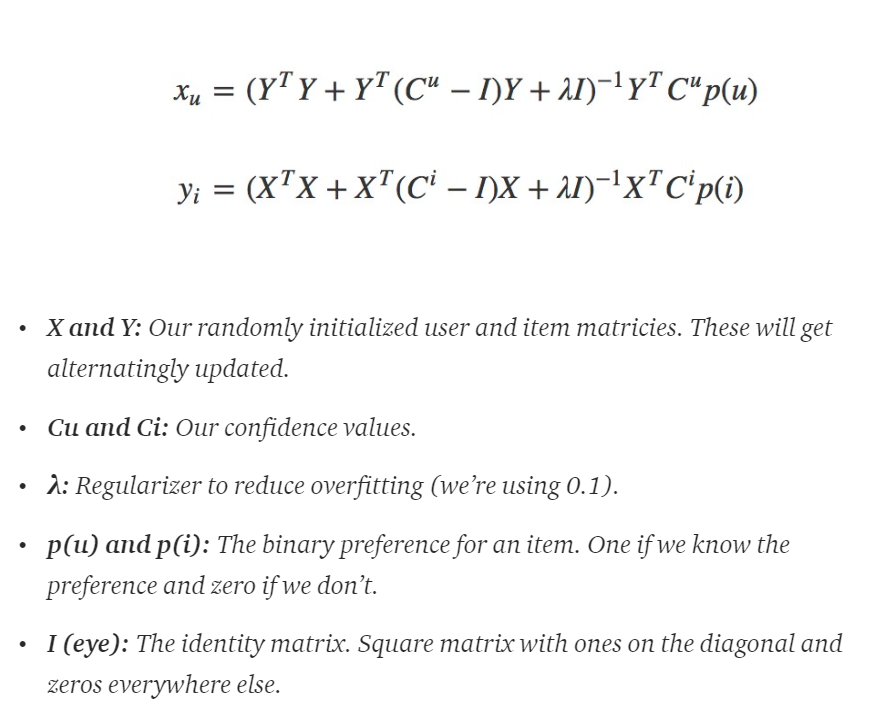

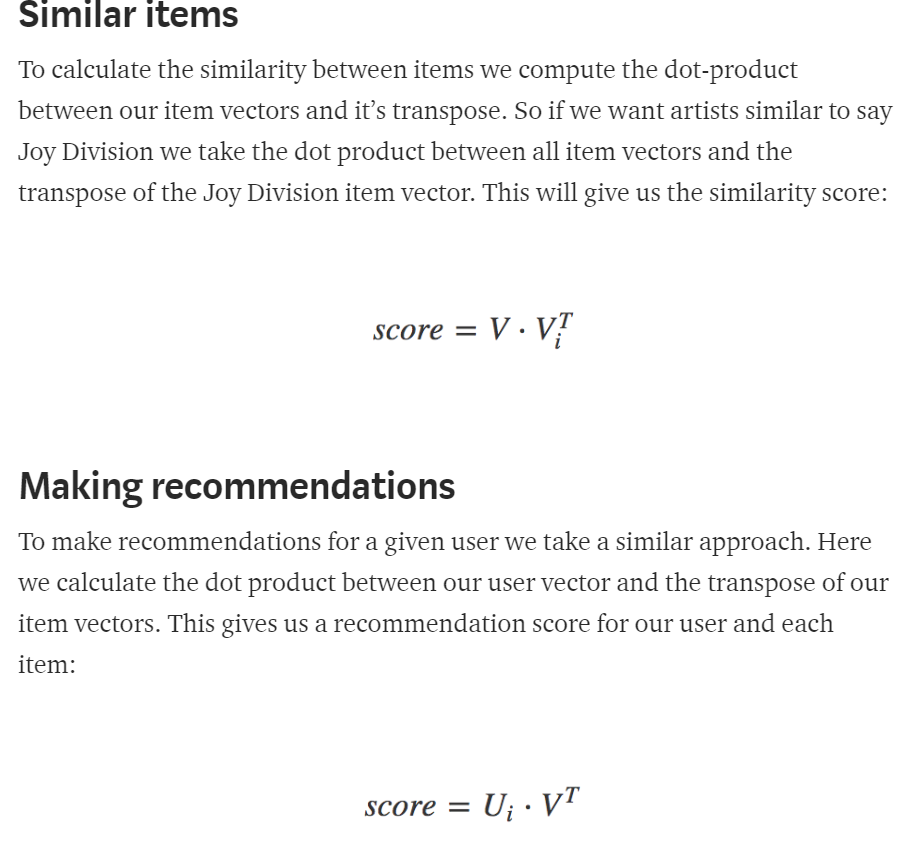

In [34]:
import random
import pandas as pd
import numpy as np

import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
from sklearn.preprocessing import MinMaxScaler

The file is a tab-separated value file and so we can still use the pandas read_csv format but use a different delimiter

In [35]:
raw_data = pd.read_csv('usersha1-artmbid-artname-plays.tsv' ,delimiter='\t',encoding='utf-8')
raw_data.head()

,00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,2137
0,00000c289a1829a808ac09c00daf10bc3c4e223b,f2fb0ff0-5679-42ec-a55c-15109ce6e320,die Ärzte,1099
1,00000c289a1829a808ac09c00daf10bc3c4e223b,b3ae82c2-e60b-4551-a76d-6620f1b456aa,melissa etheridge,897
2,00000c289a1829a808ac09c00daf10bc3c4e223b,3d6bbeb7-f90e-4d10-b440-e153c0d10b53,elvenking,717
3,00000c289a1829a808ac09c00daf10bc3c4e223b,bbd2ffd7-17f4-4506-8572-c1ea58c3f9a8,juliette & the licks,706
4,00000c289a1829a808ac09c00daf10bc3c4e223b,8bfac288-ccc5-448d-9573-c33ea2aa5c30,red hot chili peppers,691


Let us rename the columns so that we can index it better

In [36]:
raw_data = raw_data.drop(raw_data.columns[1], axis=1)
raw_data.columns = ['user', 'artist', 'plays']

In [37]:
raw_data.head()

,user,artist,plays
0,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099
1,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
2,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
3,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706
4,00000c289a1829a808ac09c00daf10bc3c4e223b,red hot chili peppers,691


Let us do some Exploratory Data Analysis

In [38]:
raw_data.shape

(17535654, 3)

In [40]:
df = raw_data.iloc[:100000]

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
user      100000 non-null object
artist    100000 non-null object
plays     100000 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.3+ MB


We have the luxuary to drop the NA data since the dataset is really huge

In [43]:
df = df.dropna()

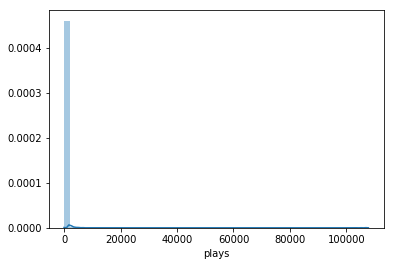

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.distplot(df['plays'])


We can see that it resembles a classic long tail situation where a few artist has a lot of plays while others have a lot lesser

In [45]:
df['user_id'] = df['user'].astype("category").cat.codes
df['artist_id'] = df['artist'].astype("category").cat.codes

In [46]:
df.head()

,user,artist,plays,user_id,artist_id
0,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099,0,5870
1,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897,0,13627
2,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717,0,6910
3,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706,0,10939
4,00000c289a1829a808ac09c00daf10bc3c4e223b,red hot chili peppers,691,0,16897


In [47]:
df.tail()

,user,artist,plays,user_id,artist_id
99995,0169cfa637a59ab654efdbe5fce27c14edf6be5a,muddy waters,41,2032,14373
99996,0169cfa637a59ab654efdbe5fce27c14edf6be5a,sam & dave,32,2032,17637
99997,0169cfa637a59ab654efdbe5fce27c14edf6be5a,little walter,28,2032,12379
99998,0169cfa637a59ab654efdbe5fce27c14edf6be5a,エレファントカシマシ,25,2032,23442
99999,0169cfa637a59ab654efdbe5fce27c14edf6be5a,teardrops,24,2032,19768


In [48]:
item_lookup = df[['artist_id', 'artist']].drop_duplicates()
item_lookup['artist_id'] = item_lookup.artist_id.astype(str)

This creates a lookup table for us to match the artist_id to the artist later

In [82]:
item_lookup

,artist_id,artist
0,5870,die Ärzte
1,13627,melissa etheridge
2,6910,elvenking
3,10939,juliette & the licks
4,16897,red hot chili peppers
5,12944,magica
6,20064,the black dahlia murder
7,20858,the murmurs
8,12770,lunachicks
9,22706,walls of jericho


In [50]:
df= df.drop(['user', 'artist'], axis=1)

In [51]:
df.head()

,plays,user_id,artist_id
0,1099,0,5870
1,897,0,13627
2,717,0,6910
3,706,0,10939
4,691,0,16897


Dropping data w 0 plays

In [52]:
df = df.loc[df.plays != 0]

In [53]:
users = list(np.sort(df.user_id.unique()))
artists = list(np.sort(df.artist_id.unique()))
plays = list(df.plays)

In [54]:
artists

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


getting the rows and columns for the matrix

In [55]:
rows = df.user_id.astype(int)
cols = df.artist_id.astype(int)

In [56]:
rows

0           0
1           0
2           0
3           0
4           0
5           0
6           0
7           0
8           0
9           0
10          0
11          0
12          0
13          0
14          0
15          0
16          0
17          0
18          0
19          0
20          0
21          0
22          0
23          0
24          0
25          0
26          0
27          0
28          0
29          0
         ... 
99970    2031
99971    2031
99972    2031
99973    2031
99974    2031
99975    2031
99976    2031
99977    2031
99978    2031
99979    2031
99980    2031
99981    2031
99982    2031
99983    2031
99984    2031
99985    2031
99986    2031
99987    2031
99988    2031
99989    2031
99990    2031
99991    2031
99992    2031
99993    2032
99994    2032
99995    2032
99996    2032
99997    2032
99998    2032
99999    2032
Name: user_id, Length: 100000, dtype: int32

Using a sparse matrix ensures that space is only used to store values and not the null values

In [57]:
# Contruct a sparse matrix for our users and items containing number of plays
data_sparse = sparse.csr_matrix((plays, (rows, cols)), shape=(len(users), len(artists)))

In [58]:
data_sparse

<2033x23689 sparse matrix of type '<class 'numpy.int32'>'
	with 99999 stored elements in Compressed Sparse Row format>

In [59]:
def implicit_als(sparse_data, alpha_val=40, iterations=1, lambda_val=0.1, features=10):
 
    """ Implementation of Alternating Least Squares with implicit data. We iteratively
    
    alpha is the confidence multiplier
    lambda is the regularisation value to prevent overfitting
    
    compute the user (x_u) and item (y_i) vectors using the following formulas:
 
    x_u = ((Y.T*Y + Y.T*(Cu - I) * Y) + lambda*I)^-1 * (X.T * Cu * p(u))
    y_i = ((X.T*X + X.T*(Ci - I) * X) + lambda*I)^-1 * (Y.T * Ci * p(i))
 
    Args:
        sparse_data (csr_matrix): Our sparse user-by-item matrix
 
        alpha_val (int): The rate in which we'll increase our confidence
        in a preference with more interactions.
 
        iterations (int): How many times we alternate between fixing and 
        updating our user and item vectors
 
        lambda_val (float): Regularization value
 
        features (int): How many latent features we want to compute.
    
    Returns:     
        X (csr_matrix): user vectors of size users-by-features
        
        Y (csr_matrix): item vectors of size items-by-features
     """

    # Calculate the foncidence for each value in our data
    confidence = sparse_data * alpha_val
    # this is from the formula above
    
    # Get the size of user rows and item columns
    user_size, item_size = sparse_data.shape
    
    # We create the user vectors X of size users-by-features, the item vectors
    # Y of size items-by-features and randomly assign the values.
    X = sparse.csr_matrix(np.random.normal(size = (user_size, features)))
    Y = sparse.csr_matrix(np.random.normal(size = (item_size, features)))
    
    #Precompute I and lambda * I
    X_I = sparse.eye(user_size) #getting the identity matrix
    Y_I = sparse.eye(item_size)
    
    I = sparse.eye(features)
    lI = lambda_val * I
    
    # Start main loop. For each iteration we first compute X and then Y
    for i in range(iterations):
        print ('iteration %d of %d' % (i+1, iterations))
        
        # Precompute Y-transpose-Y and X-transpose-X
        yTy = Y.T.dot(Y)
        xTx = X.T.dot(X)

        # Loop through all users
        for u in range(user_size):

            # Get the user row.
            u_row = confidence[u,:].toarray() 

            # Calculate the binary preference p(u)
            p_u = u_row.copy()
            p_u[p_u != 0] = 1.0

            # Calculate Cu and Cu - I , the confideence portion in the formula
            CuI = sparse.diags(u_row, [0])
            Cu = CuI + Y_I

            # Put it all together and compute the final formula
            yT_CuI_y = Y.T.dot(CuI).dot(Y)
            yT_Cu_pu = Y.T.dot(Cu).dot(p_u.T)
            X[u] = spsolve(yTy + yT_CuI_y + lI, yT_Cu_pu)

    
        for i in range(item_size):

            # Get the item column and transpose it.
            i_row = confidence[:,i].T.toarray()

            # Calculate the binary preference p(i)
            p_i = i_row.copy()
            p_i[p_i != 0] = 1.0

            # Calculate Ci and Ci - I
            CiI = sparse.diags(i_row, [0])
            Ci = CiI + X_I

            # Put it all together and compute the final formula
            xT_CiI_x = X.T.dot(CiI).dot(X)
            xT_Ci_pi = X.T.dot(Ci).dot(p_i.T)
            Y[i] = spsolve(xTx + xT_CiI_x + lI, xT_Ci_pi)

    return X, Y

In [60]:
user_vecs, item_vecs = implicit_als(data_sparse, iterations=1, features=20, alpha_val=40)

iteration 1 of 1


In [84]:
item_id = 10277
#item-id for Jay-Zb

# Get the item row for this artist
item_vec = item_vecs[item_id].T


In [85]:
# Calculate the similarity score between Mr Carter and other artists
# and select the top 10 most similar.
scores = item_vecs.dot(item_vec).toarray().reshape(1,-1)[0]
top_10 = np.argsort(scores)[::-1][:10]

We get the similarity by talking the dot product of our item vectors with the item vector of the artist.

In [87]:
artists = []
artist_scores = []

# Get and print the actual artists names and scores
for idx in top_10:
    artists.append(item_lookup.artist.loc[item_lookup.artist_id == str(idx)].iloc[0])
    artist_scores.append(scores[idx])

similar = pd.DataFrame({'artist': artists, 'score': artist_scores})

print(similar)

            artist      score
0            jay-z  12.935061
1       kanye west  11.003626
2      dir en grey   9.541174
3     skinny puppy   8.889722
4      alicia keys   8.757817
5        faithless   8.755389
6           slayer   8.502737
7       rob zombie   8.480649
8  lcd soundsystem   8.446344
9      craig david   8.292962


Now let’s generate some recommendations for a user. Here most of the code is just moving, reshaping and making the results readable. To get the actual score we take the dot product between the trained user vector and the transpose of the item vectors.

In [92]:
user_id = 2029

# Let's print out what the user has listened to
consumed_idx = data_sparse[user_id,:].nonzero()[1].astype(str)
consumed_items = item_lookup.loc[item_lookup.artist_id.isin(consumed_idx)]
print(consumed_items)


      artist_id                            artist
4         16897             red hot chili peppers
61         4642                          coldplay
192       19581                  system of a down
279       16158                        pink floyd
293       12024                      led zeppelin
373        8993                       hans zimmer
436        1189                     amy winehouse
762       14452               my chemical romance
992         132                30 seconds to mars
995        2790                      billy talent
1141      15355                       onerepublic
1399       3576           buena vista social club
1524       1594                      apocalyptica
1861       9472                      howard shore
2636       5140                         dan bárta
3027      12610                   louis armstrong
4329      15661                        papa roach
4484      18045                      serj tankian
4556       5586                       deep purple


In [94]:
def recommend(user_id, data_sparse, user_vecs, item_vecs, item_lookup, num_items=10):
    """Recommend items for a given user given a trained model
    
    Args:
        user_id (int): The id of the user we want to create recommendations for.
        
        data_sparse (csr_matrix): Our original training data.
        
        user_vecs (csr_matrix): The trained user x features vectors
        
        item_vecs (csr_matrix): The trained item x features vectors
        
        item_lookup (pandas.DataFrame): Used to map artist ids to artist names
        
        num_items (int): How many recommendations we want to return:
        
    Returns:
        recommendations (pandas.DataFrame): DataFrame with num_items artist names and scores
    
    """
  
    # Get all interactions by the user
    user_interactions = data_sparse[user_id,:].toarray()

    # We don't want to recommend items the user has consumed. So let's
    # set them all to 0 and the unknowns to 1.
    user_interactions = user_interactions.reshape(-1) + 1 #Reshape to turn into 1D array
    user_interactions[user_interactions > 1] = 0

    # This is where we calculate the recommendation by taking the 
    # dot-product of the user vectors with the item vectors.
    rec_vector = user_vecs[user_id,:].dot(item_vecs.T).toarray()

    # Let's scale our scores between 0 and 1 to make it all easier to interpret.
    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0]
    recommend_vector = user_interactions*rec_vector_scaled
   
    # Get all the artist indices in order of recommendations (descending) and
    # select only the top "num_items" items. 
    item_idx = np.argsort(recommend_vector)[::-1][:num_items]

    artists = []
    scores = []

    # Loop through our recommended artist indicies and look up the actial artist name
    for idx in item_idx:
        artists.append(item_lookup.artist.loc[item_lookup.artist_id == str(idx)].iloc[0])
        scores.append(recommend_vector[idx])

    # Create a new dataframe with recommended artist names and scores
    recommendations = pd.DataFrame({'artist': artists, 'score': scores})
    
    return recommendations

# Let's generate and print our recommendations


In [95]:
recommendations = recommend(user_id, data_sparse, user_vecs, item_vecs, item_lookup)
print(recommendations)

                     artist     score
0             kaiser chiefs  1.000000
1                 front 242  0.986984
2                      muse  0.967669
3                    fugazi  0.947502
4               kt tunstall  0.886931
5              foo fighters  0.883278
6  rage against the machine  0.869114
7              otis redding  0.858678
8                  deftones  0.857964
9       strapping young lad  0.855983


## Doing it the Implicit way 


In [100]:
import pandas as pd
import numpy as np
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import random

from sklearn.preprocessing import MinMaxScaler

import implicit # The Cython library

# Load the data like we did before
raw_data = pd.read_csv('usersha1-artmbid-artname-plays.tsv' ,delimiter='\t',encoding='utf-8')
raw_data = raw_data.drop(raw_data.columns[1], axis=1)
raw_data.columns = ['user', 'artist', 'plays']

# Drop NaN columns
data = raw_data.dropna()
data = data.copy()


# Create a numeric user_id and artist_id column
data['user'] = data['user'].astype("category")
data['artist'] = data['artist'].astype("category")
data['user_id'] = data['user'].cat.codes
data['artist_id'] = data['artist'].cat.codes

# The implicit library expects data as a item-user matrix so we
# create two matricies, one for fitting the model (item-user) 
# and one for recommendations (user-item)
sparse_item_user = sparse.csr_matrix((data['plays'].astype(float), (data['artist_id'], data['user_id'])))
sparse_user_item = sparse.csr_matrix((data['plays'].astype(float), (data['user_id'], data['artist_id'])))

# Initialize the als model and fit it using the sparse item-user matrix
model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=20)

# Calculate the confidence by multiplying it by our alpha value.
alpha_val = 15
data_conf = (sparse_item_user * alpha_val).astype('double')

#Fit the model
model.fit(data_conf)



100%|████████████████████████████████████████████████████████████████████████████████| 20.0/20 [02:30<00:00,  8.02s/it]


In [99]:
# Find the 10 most similar to Jay-Z
item_id = 147068 #Jay-Z
n_similar = 10

# Use implicit to get similar items.
similar = model.similar_items(item_id, n_similar)

# Print the names of our most similar artists
for item in similar:
    idx, score = item
    print(data.artist.loc[data.artist_id == idx].iloc[0])


NameError: name 'model' is not defined